In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import random

import os
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline

In [2]:
data_dir = './rsna-bone-age/'

data = pd.read_csv(os.path.join(data_dir,'boneage-training-dataset.csv'))

In [3]:
data['path'] = data['id'].map(lambda x: os.path.join(data_dir,'boneage-training-dataset'
                                                     ,'{}.png'.format(x)))
data['exists'] = data['path'].map(os.path.exists)
print(data['path'][0])

./rsna-bone-age/boneage-training-dataset/1377.png


In [4]:
print(data['exists'].sum(), 'images found of', data.shape[0],'total')

12611 images found of 12611 total


In [5]:
data['gender'] = data['male'].map(lambda x: 'male' if x else 'female')
data['female'] = data['male'].map(lambda x: False if x else True)
print(data.gender.value_counts())

male      6833
female    5778
Name: gender, dtype: int64


In [6]:
bone_age_mean = data['boneage'].mean()
bone_age_div = 2*data['boneage'].std()
bone_age_std = data['boneage'].std()
data['bone_age_truezscore'] = data.boneage.map(lambda x: (x-bone_age_mean)/bone_age_std)
data['bone_age_zscore'] = data.boneage.map(lambda x: (x-bone_age_mean)/bone_age_div)
data.dropna(inplace=True)
data.sample(5)

,id,boneage,male,path,exists,gender,female,bone_age_truezscore,bone_age_zscore
3189,5117,50,False,./rsna-bone-age/boneage-training-dataset/5117.png,True,female,True,-1.877537,-0.938768
4797,6890,120,True,./rsna-bone-age/boneage-training-dataset/6890.png,True,male,False,-0.177766,-0.088883
9932,12617,69,True,./rsna-bone-age/boneage-training-dataset/12617...,True,male,False,-1.416170,-0.708085
4461,6513,192,False,./rsna-bone-age/boneage-training-dataset/6513.png,True,female,True,1.570570,0.785285
6157,8405,144,False,./rsna-bone-age/boneage-training-dataset/8405.png,True,female,True,0.405013,0.202506


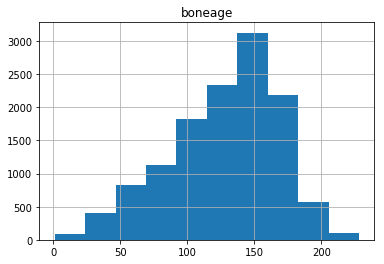

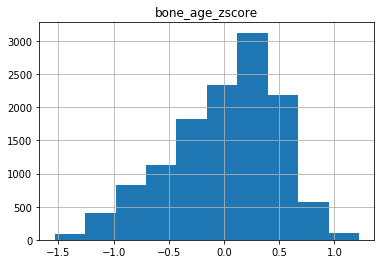

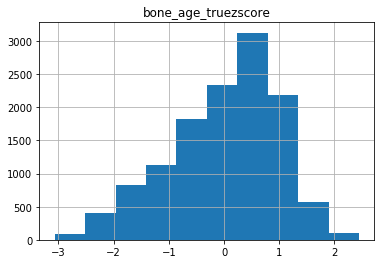

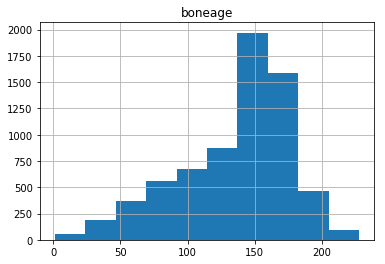

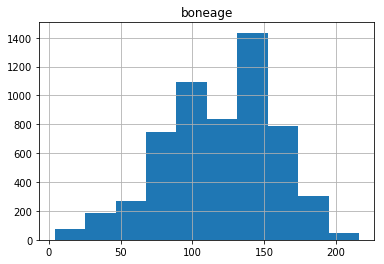

In [7]:
data.hist(column='boneage')
data.hist(column='bone_age_zscore')
data.hist(column='bone_age_truezscore')
data[data['male']].hist(column='boneage')
data[data['female']].hist(column='boneage')
count,div = np.histogram(data['boneage'])


In [8]:
data['boneage_category'] = pd.cut(data['boneage'],10)
print(data['boneage_category'][0])

(159.9, 182.6]


New train shape: 10000 pre-train shape: 12611


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f79f6b86da0>]],
      dtype=object)

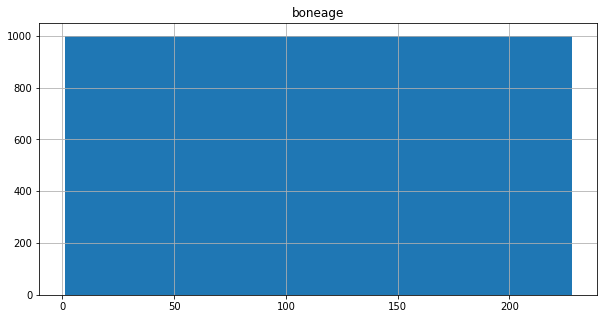

In [9]:
train_df = data.groupby(['boneage_category','male']).apply(lambda x: x.sample(500, replace=True)
                                                          ).reset_index(drop=True)
print('New train shape:', train_df.shape[0],'pre-train shape:',data.shape[0])
train_df.hist(column='boneage',figsize=(10,5))

In [17]:
# now for data selection
from sklearn.model_selection import train_test_split
data['gender'] = data['male'].map(lambda x: 1 if x else 0)

df_train, df_valid = train_test_split(train_df, test_size=0.15, 
                                      random_state=7,
                                      stratify=train_df['boneage_category'])
print('train',df_train.shape[0],'validation',df_valid.shape[0])

train 8500 validation 1500


(1609, 1163)


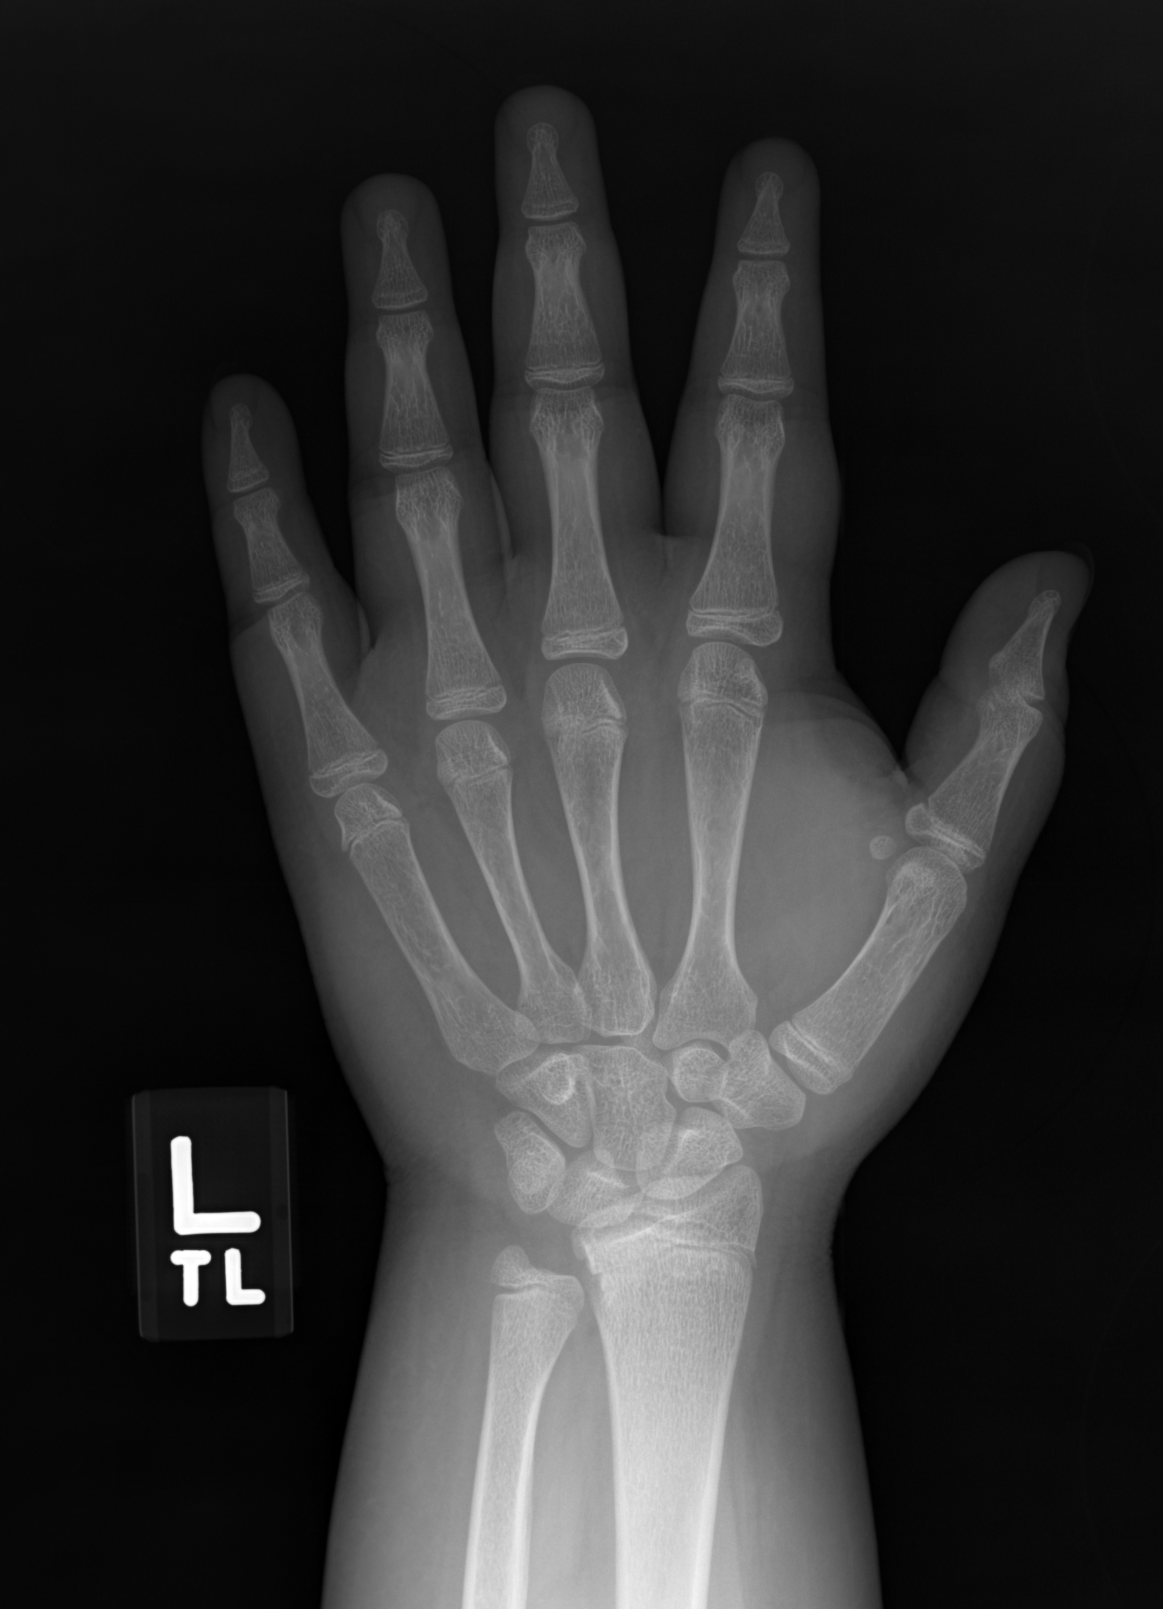

In [18]:
test = Image.open(df_train['path'][random.randint(0,df_train.shape[0])])
print(np.array(test).shape)
test

In [28]:
import imgaug as ia
from imgaug import augmenters as iaa

def normalize(image):
    image = np.array(image,dtype=np.float32)
    if image.max() > 1.0:
        image=np.interp(image,(image.min(),image.max()),(0.0,1.0))
    image = np.array(image,dtype=np.float32)
    return image

def augment_image(image):
    if not hasattr(augment_image,'pipe'):
        sometimes = lambda aug: iaa.Sometimes(0.5,aug)
        augment_image.pipe = iaa.Sequential(
            [
                iaa.SomeOf((0,6),
                    [
                        iaa.OneOf([
                                iaa.GaussianBlur((0,3.0)),
                                iaa.AverageBlur(k=(2,7)),
                                iaa.MedianBlur(k=(3,11)),
                            ]),
                        iaa.Sharpen(alpha=(0,1.0),lightness=(0.75,1.5)),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0,0.05*255),per_channel=0.5),
                        iaa.Dropout((0.01,0.075),per_channel=0.5),
                        iaa.Add((-5,5),per_channel=0.5),
#                        iaa.ContrastNormalization((0.5,2.0),per_channel=0.5),
                        iaa.Fliplr(0.5),
                        iaa.Flipud(0.5),
                        iaa.Affine(rotate=(-90,90),
                            translate_percent={"x":(-0.15,0.15),"y":(-0.15,0.15)},
                        ),
                    ],
                    random_order=True
                )
            ],
            random_order=True
        )
    #image augmentation library needs uint8, but we use float32 for training
    image = augment_image.pipe.augment_image(np.array(image,dtype=np.uint8))
    image = normalize(image)
    return image

(1609, 1163)
float32


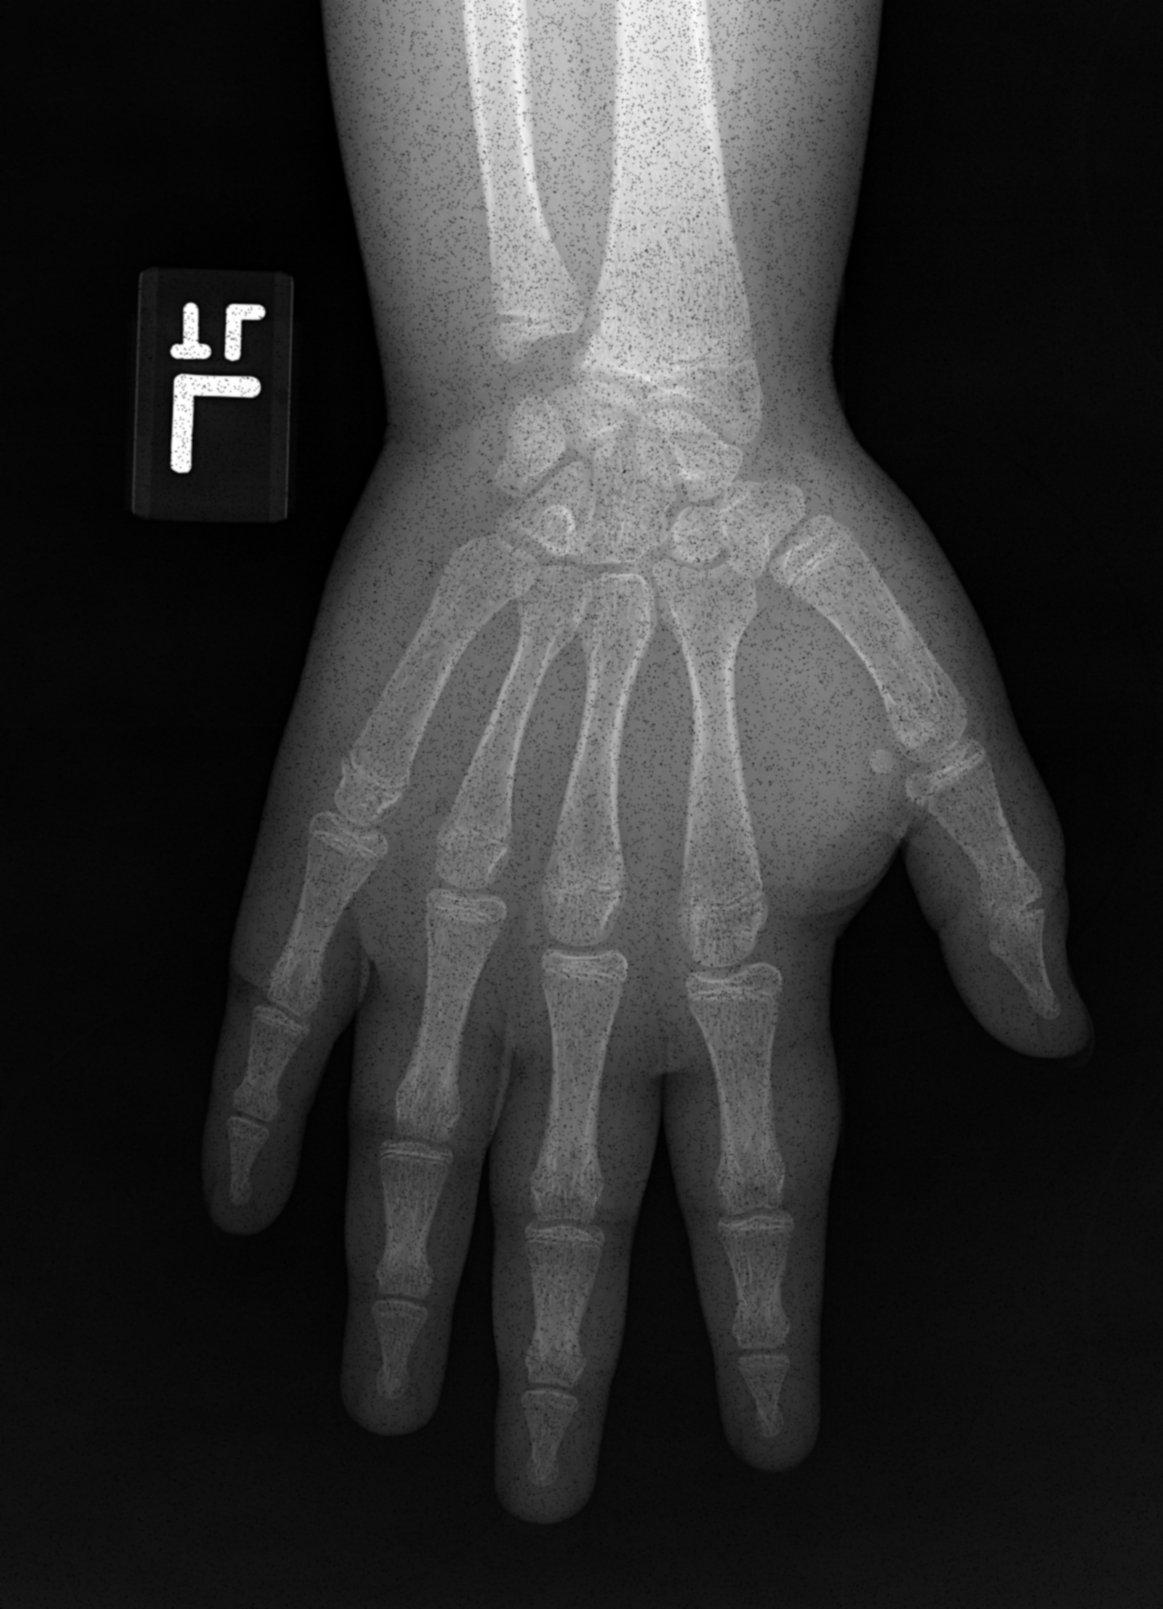

In [30]:
augmented = augment_image(np.array(test))
print(augmented.shape)
print(augmented.dtype)
Image.fromarray(augmented*255.0).convert("L")

In [14]:
def get_data(data):
    labels = []
    img_paths = []
    pbar = tqdm(data.iterrows())
    for i,row in pbar:
        labels.append(row['bone_age_zscore'])
        img_paths.append(row['path'])
    return labels, img_paths

train_labels, train_paths = get_data(df_train)
val_labels, val_paths = get_data(df_valid)

8500it [00:00, 16923.68it/s]
1500it [00:00, 16337.37it/s]


In [15]:
print(train_labels[1],train_paths[1])
print(val_labels[1],val_paths[1])

0.7852850112435631 ./rsna-bone-age/boneage-training-dataset/6205.png
0.05681178480694727 ./rsna-bone-age/boneage-training-dataset/4143.png
